
# Conditional autoregressive transformer

Train a transformer to predict missing pixel from mnist 

### plan

* note to try padded mnist (relative encoding might require black padding???)
* probably don't need positional encoding?
* create transformer model
* masking 
* randomised masking
* relative position encoding (x - current_x, y - current_y, val)
* train to predict when current pixel missing
* train to predict when 10% are missing
* train to predict when 90% are missing
* train to predict when 99% are missing



In [1]:
model_name = "txformer-bigger-3"

In [2]:
# Init weights and biases project

import wandb
from wandb.keras import WandbCallback


wandb.init(project='conditional-mnist', entity='maxeonyx')
config = wandb.config
config.learning_rate = 0.01

wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)


In [3]:
# reserve GPU 0 only (for VUW machines)

import os

os.environ['CUDA_VISIBLE_DEVICES']='0'

In [4]:
# start tensorflow

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

tf.constant([1])

2021-09-30 04:17:06.557238: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

2021-09-30 04:17:07.121051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:3b:00.0, compute capability: 7.5


In [5]:
from PIL import Image, ImageDraw
from IPython.display import display

def display_uint8_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display(Image.fromarray(image, "L"))

def display_float32_image(image):
    if len(image.shape) == 3:
        image = image[:, :, 0]
    if tf.is_tensor(image):
        image = image.numpy()
    display_uint8_image(image.astype(np.uint8))

In [34]:
def idxs_to_onehots(idxs, depth=784):
    onehots = tf.one_hot(idxs, depth, dtype=tf.bool, on_value=False, off_value=True)
    return onehots

# takes 2D tensor (batch and index list)
def idxs_to_multihot(idxs, depth=784):
    onehots = idxs_to_onehots(idxs, depth)
    multihot = tf.math.reduce_all(onehots, axis=len(onehots.shape)-2)
    return multihot

def idxs_to_attention_mask(idxs):
    multihot = idxs_to_multihot(idxs)
    attn_mask = tf.logical_and(multihot[:, :, None], multihot[:, None, :])
    return attn_mask

def mask_to_image_mask(mask):
    image_mask = tf.reshape(mask, [28, 28])
    return image_mask

# scale is the max-min of vals
# for mnist it's 28 because thats the width and height of the images
def positional_encoding(vals, dims, scale=1000):

    i = tf.range(dims//2, dtype=tf.float32)
    i = tf.expand_dims(i, -2)
    
    vals = tf.expand_dims(vals, -1)
    
    # the bit inside the sin / cos
    rate = vals / tf.pow(scale, 2.*i/dims)
    
    sin = tf.sin(rate)
    cos = tf.cos(rate)
    
    # expand dims to allow alternating concat
    sin = tf.expand_dims(sin, -1)
    cos = tf.expand_dims(cos, -1)
    
    encoding = tf.concat([sin, cos], axis=-1)
    encoding = tf.reshape(encoding, [-1, dims])
    
    return encoding

print(positional_encoding(tf.constant([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]), 8))

def img_to_tuples(img):
    
    height, width, chan = img.shape
    length = height * width
    vals = tf.reshape(img, [length, chan])
    vals = tf.cast(vals, tf.float32)
    rows = tf.range(height, dtype=tf.float32)
    cols = tf.range(width, dtype=tf.float32)
    cols, rows = tf.meshgrid(rows, cols)
    rows = tf.reshape(rows, [-1])
    cols = tf.reshape(cols, [-1])
    
    # permute the order, to ensure the network uses the positional encoding and not the implicit locaiton
    idxs = tf.range(length)
    idxs = tf.random.shuffle(idxs)
    
    rows = tf.gather(rows, idxs)
    cols = tf.gather(cols, idxs)
    vals = tf.gather(vals, idxs)
    
    return vals, rows, cols

def random_mask():
    idxs = tf.range(784)
    idxs = tf.random.shuffle(idxs)
    n = tf.random.uniform(shape=[], maxval=784, dtype=tf.int32)
    idxs = idxs[:n]
    return idxs_to_multihot(idxs)

def random_square_mask(maxsize=28):
    height = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    width = tf.random.uniform(shape=[], minval=1, maxval=maxsize, dtype=tf.int32)
    start_row = tf.random.uniform(shape=[], minval=0, maxval=maxsize-height, dtype=tf.int32)
    start_col = tf.random.uniform(shape=[], minval=0, maxval=maxsize-width, dtype=tf.int32)
    rows = tf.range(start_row, start_row + height)
    cols = tf.range(start_col, start_col + width)
    cols, rows = tf.meshgrid(rows, cols)
    idxs = rows*maxsize+cols
    idxs = tf.reshape(idxs, [-1])
    return idxs_to_multihot(idxs, depth=maxsize*maxsize)

def random_offset():
    return tf.random.uniform(shape=[2], maxval=28, dtype=tf.int32)
    
def display_mask(mask):
    image_mask = np.array(mask_to_image_mask(mask), np.uint8)
    image_mask = image_mask * 255
    display_uint8_image(image_mask)

tf.Tensor(
[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00
   0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0000000e+00]
 [ 7.0710683e-01  7.0710677e-01  1.3921213e-01  9.9026257e-01
   2.4833918e-02  9.9969161e-01  4.4166050e-03  9.9999022e-01]
 [ 1.0000000e+00 -4.3711388e-08  2.7571312e-01  9.6123999e-01
   4.9652517e-02  9.9876654e-01  8.8331243e-03  9.9996096e-01]
 [ 7.0710683e-01 -7.0710677e-01  4.0684462e-01  9.1349739e-01
   7.4440487e-02  9.9722546e-01  1.3249470e-02  9.9991220e-01]
 [-8.7422777e-08 -1.0000000e+00  5.3005296e-01  8.4796453e-01
   9.9182546e-02  9.9506927e-01  1.7665559e-02  9.9984396e-01]], shape=(5, 8), dtype=float32)


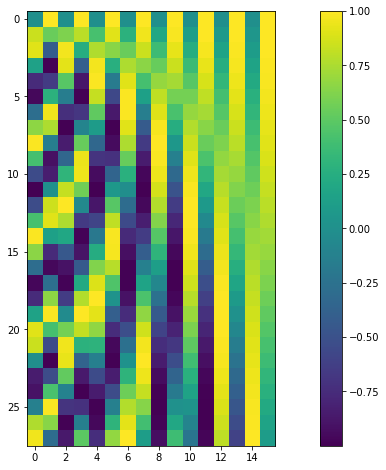

In [35]:
from matplotlib import pyplot as plt
positions = tf.range(28, dtype=tf.float32)
encodings = positional_encoding(positions, 16, scale=28)
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(encodings)
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [36]:
# tensorflow.data data generator

from tensorflow import data as td
import tensorflow_datasets as tfds

def make_dataset_generator(split='train'):
    
    def split_enumerate(i, data):
        data["index"] = i
        return data
    
    dataset = tfds.load('mnist', split=split, shuffle_files=True)
    
    dataset = dataset.enumerate()
    dataset = dataset.map(split_enumerate)
    # shuffle the digits
    dataset = dataset.shuffle(60000)
    # repeat the dataset infinitely
    dataset = dataset.repeat()
    
#     def map_just(component, func):
#         def do(data):
#             data[component] = func(data[component])
#             return data
#         return do
    
    def map_add(component, func):
        def do(data):
            data[component] = func()
            return data
        return do
    
    def add_tuples(data):
        data['vals'], data['rows'], data['cols'] = img_to_tuples(data['image'])
        return data
    
#     def offset_tuples(data):
#         offset = tf.cast(data['offset'], tf.float32)
#         data['tuples'] = tf.stack([
#             data['tuples'][:, 0],
#             data['tuples'][:, 1] + offset[0],
#             data['tuples'][:, 1] + offset[1],
#         ], axis=-1)
#         data['tuples'] = tf.random.shuffle(data['tuples'])
#         return data
    
    
#     def add_target_px_val(data):
#         offset = data['offset']
#         data['target_px'] = tf.cast(data['image'][offset[0],offset[1]], tf.float32)
#         return data
    
    def add_square_mask(data):
        mask = data['mask']
        square_mask = random_square_mask()
        mask = tf.logical_and(mask, square_mask)
        data['mask'] = mask
        return data
    
    dataset = dataset.map(add_tuples)
    # data['image'][:, 0] are vals
    # data['image'][:, 1] are rows
    # data['image'][:, 2] are cols
    
    dataset = dataset.map(map_add('mask', random_mask))
    dataset = dataset.map(add_square_mask)
#     dataset = dataset.map(map_add('offset', random_offset))
#     dataset = dataset.map(offset_tuples)
#     dataset = dataset.map(add_target_px_val)
    
#     if batch_size is not None:
#         dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset

dataset_train = make_dataset_generator()
dataset_test = make_dataset_generator(split='test')

In [39]:
def dataset_summary(d):
    for el in d.take(1):
        for name, v in el.items():
            print(name, "shape", v.shape)
            print(name, "dtype", v.dtype)

    for el in d.take(5):
        print("index", el["index"], "which is a", el["label"])
        display_uint8_image(el["image"])
        display_mask(el["mask"])
        display_uint8_image(tf.reshape(el["image"], [28, 28]) * tf.cast(mask_to_image_mask(el["mask"]), tf.uint8))

dataset_summary(dataset_train)
dataset_summary(dataset_test)

image shape (28, 28, 1)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'int64'>
index shape ()
index dtype <dtype: 'int64'>
vals shape (784, 1)
vals dtype <dtype: 'float32'>
rows shape (784,)
rows dtype <dtype: 'float32'>
cols shape (784,)
cols dtype <dtype: 'float32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
index tf.Tensor(31512, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=int64)


index tf.Tensor(39285, shape=(), dtype=int64) which is a tf.Tensor(2, shape=(), dtype=int64)


index tf.Tensor(51144, shape=(), dtype=int64) which is a tf.Tensor(5, shape=(), dtype=int64)


index tf.Tensor(41627, shape=(), dtype=int64) which is a tf.Tensor(7, shape=(), dtype=int64)


index tf.Tensor(9095, shape=(), dtype=int64) which is a tf.Tensor(5, shape=(), dtype=int64)


image shape (28, 28, 1)
image dtype <dtype: 'uint8'>
label shape ()
label dtype <dtype: 'int64'>
index shape ()
index dtype <dtype: 'int64'>
vals shape (784, 1)
vals dtype <dtype: 'float32'>
rows shape (784,)
rows dtype <dtype: 'float32'>
cols shape (784,)
cols dtype <dtype: 'float32'>
mask shape (784,)
mask dtype <dtype: 'bool'>
index tf.Tensor(2500, shape=(), dtype=int64) which is a tf.Tensor(6, shape=(), dtype=int64)


index tf.Tensor(216, shape=(), dtype=int64) which is a tf.Tensor(9, shape=(), dtype=int64)


index tf.Tensor(190, shape=(), dtype=int64) which is a tf.Tensor(3, shape=(), dtype=int64)


index tf.Tensor(5082, shape=(), dtype=int64) which is a tf.Tensor(0, shape=(), dtype=int64)


index tf.Tensor(6152, shape=(), dtype=int64) which is a tf.Tensor(9, shape=(), dtype=int64)


In [11]:

# f_masks = np.array([29, 31, 754, 752])
# print(f_masks)
# f_masks = idxs_to_multihot(f_masks)
# print(f_masks)
# display_mask(f_masks)

# t_masks = np.indices([784])
# print(t_masks)
# t_masks = idxs_to_multihot(t_masks)
# print(t_masks)
# display_mask(t_masks)

In [12]:

print(test_dataset["tuples"].shape, test_dataset["offsets"].shape, test_dataset["target_pxs"].shape)
print(test_dataset["tuples"][0])
print(test_dataset["offsets"][0])
print(test_dataset["target_pxs"][0])

# actual training dataset is 784 x,y,v tuples, but with the spatial location changed so the the pixel to predict is in the center
# and the pixel value to predict removed (via masking)

# then, can mask more and more stuff and compare performance

# we can also use the model in an "iterative" mode to generate images, in an arbitrary order.

(10000, 784, 3) (10000, 2) (10000,)
tf.Tensor(
[[ 11.   1.   0.]
 [ -5. -19.   0.]
 [ -8. -17.   0.]
 ...
 [  1. -26.   0.]
 [  2. -25.   0.]
 [  5. -14.   0.]], shape=(784, 3), dtype=float32)
tf.Tensor([10 26], shape=(2,), dtype=int64)
tf.Tensor(0.0, shape=(), dtype=float32)


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
# attention manual calculation example

m = tf.constant([[5, 3], [1, 2]], dtype=tf.float32)
val = tf.constant([[5, 3], [1, 4], [1, 6]], dtype=tf.float32)
print(val)
mask = tf.constant([1, 0, 1], dtype=tf.float32)
wei = tf.constant([[1, 2, 3], [0.5, 2, 2], [1, 3, 1]], dtype=tf.float32)
wei = keras.layers.Softmax()(wei, mask)
print(wei)
val = tf.expand_dims(val, -3)
print(val.shape)
wei = tf.expand_dims(wei, -1)
print(wei.shape)
x = val * wei
print(x.shape)
print(x)
mask = tf.expand_dims(mask, -1)
# x = x * mask
print(x)
x = tf.reduce_sum(x, axis=-2)
print(x)

tf.Tensor(
[[5. 3.]
 [1. 4.]
 [1. 6.]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[0.11920292 0.         0.880797  ]
 [0.18242551 0.         0.81757444]
 [0.5        0.         0.5       ]], shape=(3, 3), dtype=float32)
(1, 3, 2)
(3, 3, 1)
(3, 3, 2)
tf.Tensor(
[[[0.5960146  0.35760877]
  [0.         0.        ]
  [0.880797   5.2847824 ]]

 [[0.91212755 0.54727656]
  [0.         0.        ]
  [0.81757444 4.9054465 ]]

 [[2.5        1.5       ]
  [0.         0.        ]
  [0.5        3.        ]]], shape=(3, 3, 2), dtype=float32)
tf.Tensor(
[[[0.5960146  0.35760877]
  [0.         0.        ]
  [0.880797   5.2847824 ]]

 [[0.91212755 0.54727656]
  [0.         0.        ]
  [0.81757444 4.9054465 ]]

 [[2.5        1.5       ]
  [0.         0.        ]
  [0.5        3.        ]]], shape=(3, 3, 2), dtype=float32)
tf.Tensor(
[[1.4768116 5.642391 ]
 [1.729702  5.452723 ]
 [3.        4.5      ]], shape=(3, 2), dtype=float32)


## Attention Maths

Dimensions $N$, $D$, $E$ and $B$.

- $N = 784$ is the number of inputs.
- $D$ is the width of the _key_ $K$ and _query_ $Q$ vectors.
- $E$ is the width of the _value_ vectors $V$.
- There is also a (or multiple) batch dimension(s) $B$.

$K$ is $B \times N \times D$ dimensional.
$Q$ is $B \times N \times D$ dimensional.
$V$ is $B \times N \times E$ dimensional.
Because it is self-attention, $K$ and $Q$ have the same length $N$, and the attention matrix is square.
The attention matrix is $A = Q \cdot K^T$, and is $B \times N \times N$ dimensional. Formally:
$$
A_{b,i,j} = \sum_d Q_{b,i,d} K_{b,j,d}
$$

We do softmax normalization along the columns $j$ of the attention matrix (such that each _row_ $i$ sums to 1). The result is the attention weights. Formally:
$$
\bar{A}_{b,i,j} = \frac{e^{A_{b,i,j}}}{\sum_{j'} e^{A_{b,i,j'}}}
$$

The output $O$ of the attention layer is $B \times N \times E$ dimensional. It is obtained by the attention weights multiplied by the value vectors $V$. $A$ is $B \times N \times N$ dimensional and $V$ is $B \times N \times E$ dimensional.
$$
    O_{b,i,e} = \sum_j A_{b,i,j} V_{b,j,e}
$$

Often the dimensions $E = D$ because this allows multiple attention layers in sequence, but this need not be the case.

In [15]:



def multi_head_attention(n_heads, n_kq_dim, n_val_dim):
    
    k_dense = layers.Dense(n_kq_dim, activation='linear')
    q_dense = layers.Dense(n_kq_dim, activation='linear')
    
    
    
    softmax = layers.Softmax(axis=-1)
    
    val_dense = layers.Dense(n_val_dim, activation='relu')
    
    def call(inputs, mask):
        
        k = k_dense(inputs)
        q = q_dense(inputs)
        
        scores = tf.matmul(query, key, transpose_b=True)
        weights = softmax(scores, mask)
        
        vals = val_dense(inputs)
        
        vals = tf.expand_dims(-1)
        weights = tf.expand_dims(-2)
        
        outputs = tf.reduce_sum(vals * weights)
        
        
        vals *= mask
        

def transformer_block(n_embed_dim, n_heads, n_dense_dim, dropout_rate):
    attn = layers.MultiHeadAttention(num_heads=n_heads, key_dim=n_embed_dim)
    dense_net_1 = layers.Dense(n_dense_dim, activation='relu')
    dense_net_2 = layers.Dense(n_embed_dim)
    layernorm1 = layers.LayerNormalization(epsilon=1e-6)
    layernorm2 = layers.LayerNormalization(epsilon=1e-6)
    dropout1 = layers.Dropout(dropout_rate)
    dropout2 = layers.Dropout(dropout_rate)
    
    def call(inputs, masks, include_residual):
        mask = tf.logical_and(masks[:, :, None], masks[:, None, :])
        attn_output = attn(inputs, inputs, attention_mask=mask)
        attn_output = dropout1(attn_output)
        if include_residual:
            attn_output = inputs + attn_output
        # mask outputs. important! without, model learns magic powers (can detect and use verrrrrrry small numbers which are not literally 0)
        attn_output = attn_output * tf.expand_dims(tf.cast(masks, tf.float32), -1)
        attn_output = layernorm1(attn_output)
        dense_output = dense_net_1(attn_output)
        dense_output = dense_net_2(dense_output)
        dense_output = dropout2(dense_output)
        return layernorm2(attn_output + dense_output)
    
    return call
    



In [16]:
def model(batch_size):

    # no batch size to start makes it simpler
    n_embd = 20

    vals = keras.Input(shape=[784], name='vals', batch_size=batch_size)
    rows = keras.Input(shape=[784], name='rows', batch_size=batch_size)
    cols = keras.Input(shape=[784], name='cols', batch_size=batch_size)
    mask = keras.Input(shape=[784], name='mask', batch_size=batch_size, dtype=tf.bool)
    
    rows_pos_enc = positional_encoding(rows, n_embd//2)
    cols_pos_enc = positional_encoding(cols, n_embd//2)
    
    pos_enc = tf.concat([rows_pos_enc, cols_pos_enc], axis=-2)
    
    m = vals
    
    # produce images of the attention/relevance/contribution for each output.

    # make it smaller
    # - less heads
    # - less dense layers
    # - smaller layer sizes'
    
    # look at standard transformer structure again.
    # what is the expected training time?
    
    # simple setup -> build up.
    
    # literature / other task at the same time
    # have enough to get help from supervisors in discussion
    # start writing
    
    # make n_embd-dimensional input embeddings per pixel from [x, y, v]
    # embedding
    m = layers.Dense(n_embd, activation='relu')(m)
    
    m = m + pos_enc
    
    m = transformer_block(n_embed_dim=n_embd, n_heads=12, n_dense_dim=200, dropout_rate=0.1)(m, masks=mask, include_residual=True)
    m = transformer_block(n_embed_dim=n_embd, n_heads=12, n_dense_dim=200, dropout_rate=0.1)(m, masks=mask, include_residual=True)
    
    m = layers.Reshape((28, 28, n_embd))(m)
    m = layers.Dense(1, activation=None)(m)

    model = keras.Model(inputs=[vals, rows, cols, mask], outputs=[m])

    return model


In [17]:
batch_size=16

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
lr_metric = get_lr_metric(optimizer)

txformer = model(batch_size)
txformer.compile(optimizer=optimizer, loss='mse', metrics=['MeanAbsoluteError', lr_metric])

def fit_one_epoch(dataset):
    txformer.fit(x=[dataset["tuples"], dataset["masks"]], y=dataset["images"], epochs=1, batch_size=batch_size, callbacks=[WandbCallback()])

load_saved_model = False
if load_saved_model:
    txformer.load_weights(f"./models/{model_name}")

txformer.summary()


ValueError: Dimensions must be equal, but are 16 and 25088 for '{{node tf.__operators__.add/AddV2}} = AddV2[T=DT_FLOAT](Placeholder, Placeholder_1)' with input shapes: [16,20], [25088,10].

In [ ]:


# display:
# - before mask
# - mask
# - after mask
# - prediction
def gen_image(dataset, idx):
    img = np.zeros([28, 28])
    mask = dataset["masks"][idx:idx+1] # slice to keep batch dim
    erow, ecol = dataset["offsets"][idx]

    image_mask = np.array(mask_to_image_mask(mask[np.newaxis, :]), np.uint8)[0]
    masked_image = np.copy(dataset["images"][idx])
    
    print("MNIST idx", idx, "which is a", dataset['digits'][idx])
    
    display_uint8_image(masked_image) # before mask
    display_uint8_image(image_mask * 255) # mask
    masked_image = masked_image * image_mask
    display_uint8_image(masked_image) # after mask
    
    img_tups = dataset["tuples"][idx:idx+1] # slice to keep batch dim
    img = txformer([img_tups, mask])
    img = tf.reshape(img, [28, 28])
    display_float32_image(img)

def image_performance_test():
    gen_image(test_dataset, 0)
    gen_image(test_dataset, 1)
    gen_image(test_dataset, 2)
    
    # full masks dataset as sanity test
    gen_image(full_masks_dataset, 0)
    gen_image(full_masks_dataset, 1)
    gen_image(full_masks_dataset, 2)


In [ ]:
image_performance_test()

In [ ]:
fit_one_epoch(train_dataset)

In [ ]:
image_performance_test()


In [ ]:
fit_one_epoch(train_dataset)

In [ ]:
image_performance_test()


In [ ]:
fit_one_epoch(train_dataset)

In [ ]:
image_performance_test()


In [ ]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")

In [ ]:
for i in range(20):
    gen_image(test_dataset, i)

In [ ]:
fit_one_epoch(train_dataset)
fit_one_epoch(train_dataset)
fit_one_epoch(train_dataset)
fit_one_epoch(train_dataset)

In [ ]:
for i in range(20):
    gen_image(test_dataset, i)

In [ ]:


if not load_saved_model:
    txformer.save_weights(f"./models/{model_name}")